In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from scipy.interpolate import griddata
import cartopy.crs as ccrs
from matplotlib.animation import FuncAnimation
import cartopy.feature as cfeature
from scipy.stats import binned_statistic_2d as histo2D

c:\Users\virtanem\Anaconda3\envs\gradu\Lib\site-packages\pyproj\__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
path = 'data/filtered20230118.csv'

dtypes = {'gps_site': str,
 'sat_id': str,
 'gdlatr': float,
 'gdlonr': float,
 'los_tec': float,
 'tec': float,
 'azm': float,
 'elm': float,
 'gdlat': float,
 'glon': float,
 'gnss_type': str,
 'slant_f': float,
 'vtec': float,
 'pair_id': str,
 'curve_id': int,
 'filtered': float,
 'blrmvd': float}

raw = pd.read_csv(path, dtype=dtypes)

raw['datetime'] = pd.to_datetime(raw['datetime'])

## Delete the first and last 15 mins of each curve + elevation filter + filter out night time data + change interval to 1 minute

In [3]:
MIN_ELEVATION = 40
DAYTIME = [6, 16]
blip = False

def trim_curve(group):
    group = group.sort_values('datetime')
    start_time = group['datetime'].iloc[0] + timedelta(minutes=15)
    end_time = group['datetime'].iloc[-1] - timedelta(minutes=15)
    return group[(group['datetime'] >= start_time) & (group['datetime'] <= end_time)]

data = raw.groupby(['pair_id', 'curve_id']).apply(trim_curve).reset_index(drop=True)

data = data[(data['datetime'].dt.hour >=  DAYTIME[0]) & 
            (data['datetime'].dt.hour < DAYTIME[1]) & 
            (data['elm'] > MIN_ELEVATION)]

if not blip:
    data['datetime'] = data['datetime'].dt.floor('5min')  

C:\Users\virtanem\AppData\Local\Temp\ipykernel_18924\3312114190.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = raw.groupby(['pair_id', 'curve_id']).apply(trim_curve).reset_index(drop=True)


C:\Users\virtanem\AppData\Local\Temp\ipykernel_26556\692763241.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = raw.groupby(['pair_id', 'curve_id']).apply(trim_curve).reset_index(drop=True)


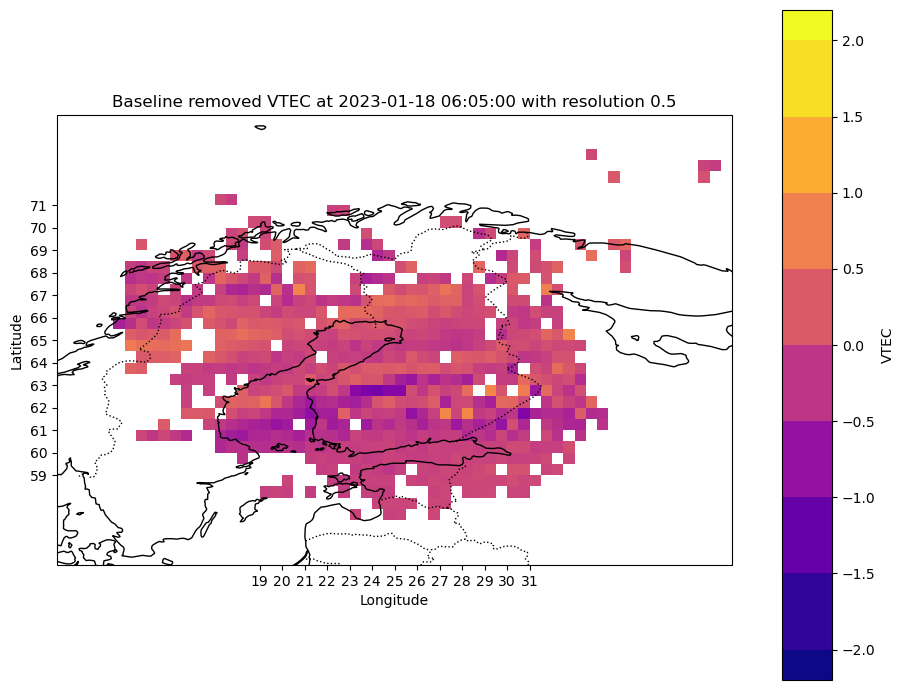

In [47]:
RES = 0.5

def histo(frame):
    df1 = data.loc[data['datetime'] == frame]
    ax.set_title(f'Baseline removed VTEC at {frame} with resolution {RES}')

    statistic, x_edges, y_edges, _ = histo2D(
        df1['glon'], df1['gdlat'], df1['blrmvd'], statistic='mean', 
        bins=[np.arange(10, 40 + RES, RES), np.arange(55, 75 + RES, RES)]) # type: ignore

    X, Y = np.meshgrid((x_edges[:-1] + x_edges[1:]) / 2, (y_edges[:-1] + y_edges[1:]) / 2)
    
    for c in ax.collections:
        c.remove()
    
    ax.pcolormesh(X, Y, statistic.T, cmap='plasma', vmin=-2, vmax=2, 
                        transform=ccrs.PlateCarree())
    
data['datetime'] = data['datetime'].dt.floor('min')    
    

frames = sorted(data['datetime'].unique())
df0 = data.loc[data['datetime'] == frames[0]]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})

ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.set_xticks(np.arange(19, 32, 1))
ax.set_yticks(np.arange(59, 72, 1))
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_xlim(10, 40)
ax.set_ylim(55, 75)
ax.set_title(f'Baseline removed VTEC at {frames[0]} with resolution {RES}')

statistic, x_edges, y_edges, _ = histo2D(
    df0['glon'], df0['gdlat'], df0['blrmvd'], statistic='mean', 
    bins=[np.arange(10, 40 + RES, RES), np.arange(55, 75 + RES, RES)]) # type: ignore

X, Y = np.meshgrid((x_edges[:-1] + x_edges[1:]) / 2, (y_edges[:-1] + y_edges[1:]) / 2)
contour = ax.pcolormesh(X, Y, statistic.T, cmap='plasma', vmin=-2, vmax=2, 
                    transform=ccrs.PlateCarree())
    


fig.subplots_adjust(right=0.8)
cax = fig.add_axes([0.85, 0.155, 0.05, 0.67]) # type: ignore

cbar = plt.colorbar(contour, cax=cax, orientation='vertical',
                    extendrect = True, label='VTEC',
                    ticks=np.arange(-2,2.5,0.5),
                    boundaries = np.arange(-2,2.5,0.5), 
                    extend='both'
)


animation = FuncAnimation(fig, histo, frames=frames[1:10], interval=80) # type: ignore

animation.save(f'animations/optimising/elevation/el{MIN_ELEVATION}.gif', writer='pillow')

## Creating the animation

### blip pierce points

In [4]:
def pp(frame):
    df1 = data.loc[data['datetime'] == frame]
    ax.set_title(f'Baseline removed VTEC at {frame}') # type: ignore

    for c in ax.collections: # type: ignore
        c.remove()

    ax.scatter(df1['glon'], df1['gdlat'],c= df1['blrmvd'], cmap='plasma', vmin=-2, vmax=2) # type: ignore

In [5]:
if blip:  
   
    frames = sorted(data['datetime'].unique())
    df0 = data.loc[data['datetime'] == frames[0]]

    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})

    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.set_xticks(np.arange(19, 32, 1))
    ax.set_yticks(np.arange(59, 72, 1))
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_xlim(10, 40)
    ax.set_ylim(55, 75)

    contour = ax.scatter(df0['glon'], df0['gdlat'],c= df0['blrmvd'], cmap='plasma', vmin=-2, vmax=2)

    fig.subplots_adjust(right=0.8)
    cax = fig.add_axes([0.85, 0.155, 0.05, 0.67]) # type: ignore

    cbar = plt.colorbar(contour, cax=cax, orientation='vertical',
                        extendrect = True, label='VTEC',
                        ticks=np.arange(-2,2.5,0.5),
                        boundaries = np.arange(-2,2.5,0.5), 
                        extend='both'
    )

    animation = FuncAnimation(fig, pp, frames=frames[1:10], interval=30) # type: ignore

    animation.save('blip_animation.gif')

    data['datetime'] = data['datetime'].dt.floor('min')


### pierce points

MovieWriter ffmpeg unavailable; using Pillow instead.


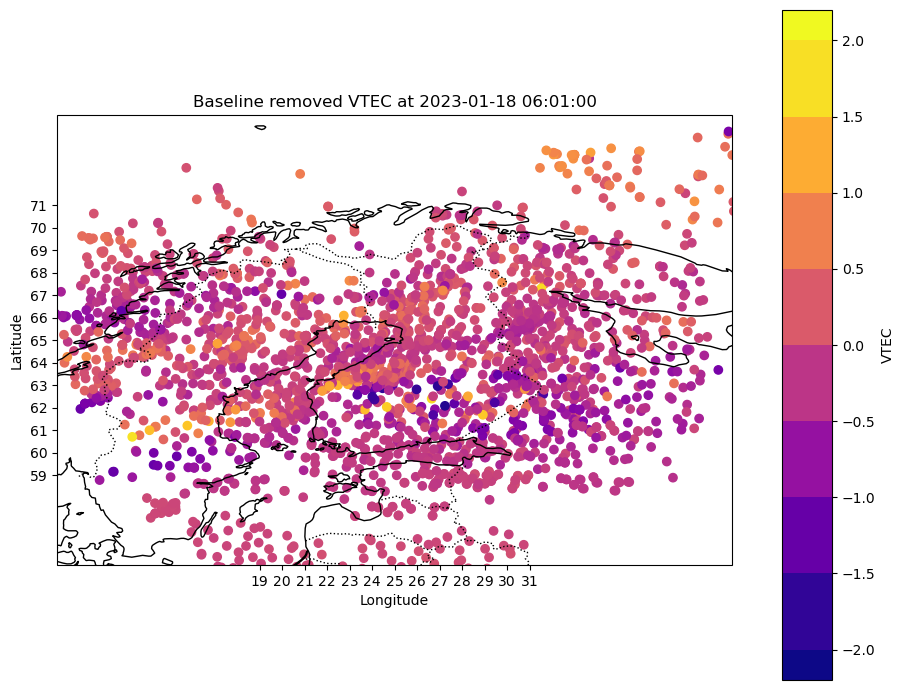

In [6]:
frames = sorted(data['datetime'].unique())
df0 = data.loc[data['datetime'] == frames[0]]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})

ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.set_xticks(np.arange(19, 32, 1))
ax.set_yticks(np.arange(59, 72, 1))
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_xlim(10, 40)
ax.set_ylim(55, 75)

contour = ax.scatter(df0['glon'], df0['gdlat'],c= df0['blrmvd'], cmap='plasma', vmin=-2, vmax=2)

fig.subplots_adjust(right=0.8)
cax = fig.add_axes([0.85, 0.155, 0.05, 0.67]) # type: ignore

cbar = plt.colorbar(contour, cax=cax, orientation='vertical',
                    extendrect = True, label='VTEC',
                    ticks=np.arange(-2,2.5,0.5),
                    boundaries = np.arange(-2,2.5,0.5), 
                    extend='both'
)

animation = FuncAnimation(fig, pp, frames=frames[1:], interval=30) # type: ignore

animation.save('pp_animation.gif')

### 2D histogram

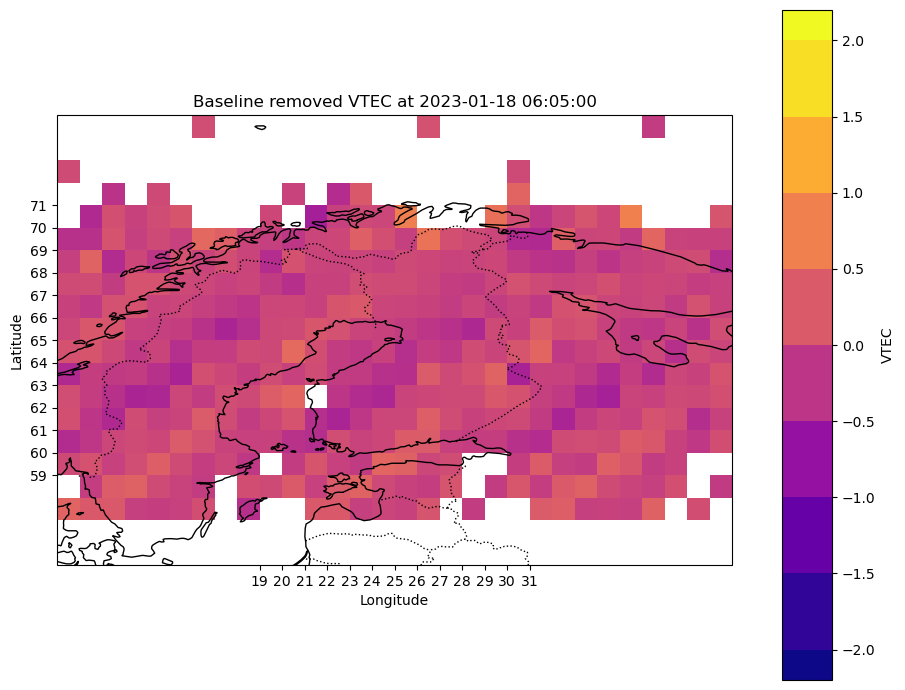

In [15]:
RES = [0.15, 1]

def histo(frame):
    df1 = data.loc[data['datetime'] == frame]
    ax.set_title(f'Baseline removed VTEC at {frame}')

    statistic, x_edges, y_edges, _ = histo2D(
        df1['glon'], df1['gdlat'], df1['blrmvd'], statistic='mean', 
        bins=[np.arange(10, 40 + RES[0], RES[0]), np.arange(55, 75 + RES[0], RES[0])]) # type: ignore

    X, Y = np.meshgrid((x_edges[:-1] + x_edges[1:]) / 2, (y_edges[:-1] + y_edges[1:]) / 2)
    
    x_flat = X.flatten()
    y_flat = Y.flatten()
    z_flat = statistic.flatten()

    valid = ~np.isnan(z_flat)
    x_valid = x_flat[valid]
    y_valid = y_flat[valid]
    z_valid = z_flat[valid]

    statistic, x_edges, y_edges, _ = histo2D(
        x_valid, y_valid, z_valid, statistic='mean', 
        bins=[np.arange(10, 40 + RES[1], RES[1]), np.arange(55, 75 + RES[1], RES[1])]) # type: ignore

    X, Y = np.meshgrid((x_edges[:-1] + x_edges[1:]) / 2, (y_edges[:-1] + y_edges[1:]) / 2)
    

    for c in ax.collections:
        c.remove()
    
    ax.pcolormesh(X, Y, statistic.T, cmap='plasma', vmin=-2, vmax=2, 
                        transform=ccrs.PlateCarree())
    
data['datetime'] = data['datetime'].dt.floor('min')    
    

frames = sorted(data['datetime'].unique())
df0 = data.loc[data['datetime'] == frames[0]]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})

ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.set_xticks(np.arange(19, 32, 1))
ax.set_yticks(np.arange(59, 72, 1))
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_xlim(10, 40)
ax.set_ylim(55, 75)
ax.set_title(f'Baseline removed VTEC at {frames[0]}')

statistic, x_edges, y_edges, _ = histo2D(
    df0['glon'], df0['gdlat'], df0['blrmvd'], statistic='mean', 
    bins=[np.arange(10, 40 + RES[0], RES[0]), np.arange(55, 75 + RES[0], RES[0])]) # type: ignore

X, Y = np.meshgrid((x_edges[:-1] + x_edges[1:]) / 2, (y_edges[:-1] + y_edges[1:]) / 2)

x_flat = X.flatten()
y_flat = Y.flatten()
z_flat = statistic.flatten()

valid = ~np.isnan(z_flat)
x_valid = x_flat[valid]
y_valid = y_flat[valid]
z_valid = z_flat[valid]

statistic, x_edges, y_edges, _ = histo2D(
    x_valid, y_valid, z_valid, statistic='mean', 
    bins=[np.arange(10, 40 + RES[1], RES[1]), np.arange(55, 75 + RES[1], RES[1])]) # type: ignore

X, Y = np.meshgrid((x_edges[:-1] + x_edges[1:]) / 2, (y_edges[:-1] + y_edges[1:]) / 2)

contour = ax.pcolormesh(X, Y, statistic.T, cmap='plasma', vmin=-2, vmax=2, 
                    transform=ccrs.PlateCarree())
    


fig.subplots_adjust(right=0.8)
cax = fig.add_axes([0.85, 0.155, 0.05, 0.67]) # type: ignore

cbar = plt.colorbar(contour, cax=cax, orientation='vertical',
                    extendrect = True, label='VTEC',
                    ticks=np.arange(-2,2.5,0.5),
                    boundaries = np.arange(-2,2.5,0.5), 
                    extend='both'
)


animation = FuncAnimation(fig, histo, frames=frames[1:50], interval=80) # type: ignore

animation.save(f'test1.gif', writer='pillow')

### griddata

MovieWriter ffmpeg unavailable; using Pillow instead.


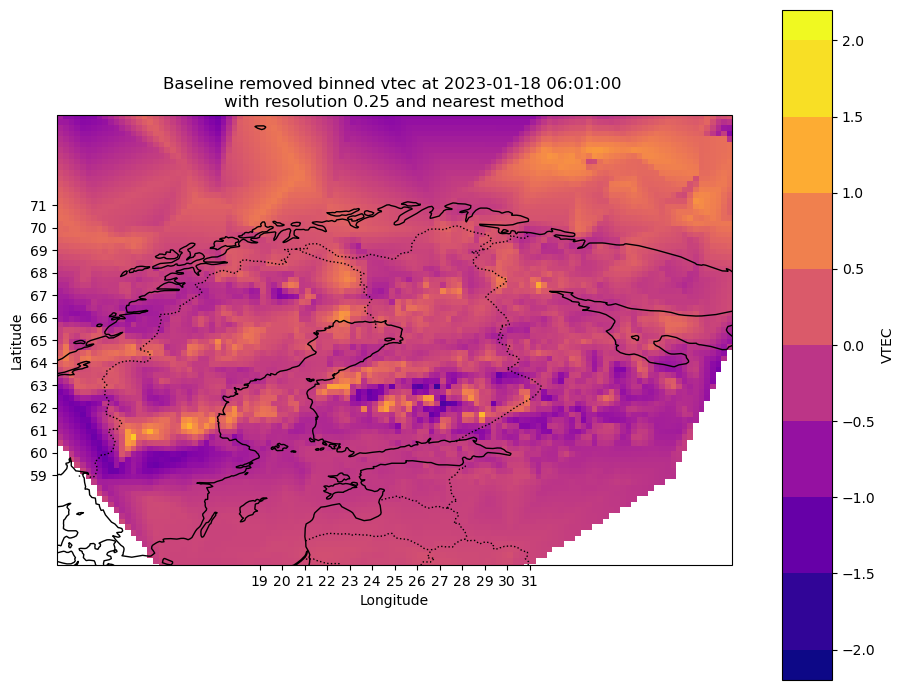

In [8]:
METHOD = 'nearest'
RES = 0.25

def grid(frame):
    df1 = data.loc[data['datetime'] == frame]
    ax.set_title(f'Baseline removed binned vtec at {frame} \nwith resolution {RES} and {METHOD} method')
    Z = griddata((df1['glon'], df1['gdlat']), df1['blrmvd'], (X, Y))

    for c in ax.collections:
        c.remove()

    ax.pcolormesh(x_grid, y_grid, Z, cmap='plasma', shading='nearest', vmin=-2, vmax=2)


frames = sorted(data['datetime'].unique())
df0 = data.loc[data['datetime'] == frames[0]]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})

ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.set_xticks(np.arange(19, 32, 1))
ax.set_yticks(np.arange(59, 72, 1))
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_xlim(10, 40)
ax.set_ylim(55, 75)
ax.set_title(f'Baseline removed binned vtec at {frames[0]} \nwith resolution {RES} and {METHOD} method')

x_grid = np.arange(min(data['glon']), max(data['glon']) + RES, RES)
y_grid = np.arange(min(data['gdlat']), max(data['gdlat']) + RES, RES)
X, Y = np.meshgrid(x_grid, y_grid)
Z = griddata((df0['glon'], df0['gdlat']), df0['blrmvd'], (X, Y))

contour = ax.pcolormesh(x_grid, y_grid, Z, cmap='plasma', shading='nearest', vmin=-2, vmax=2)    



fig.subplots_adjust(right=0.8)
cax = fig.add_axes([0.85, 0.155, 0.05, 0.67]) # type: ignore

cbar = plt.colorbar(contour, cax=cax, orientation='vertical',
                    extendrect = True, label='VTEC',
                    ticks=np.arange(-2,2.5,0.5),
                    boundaries = np.arange(-2,2.5,0.5), 
                    extend='both'
)


animation = FuncAnimation(fig, grid, frames=frames[1:], interval=30) # type: ignore

animation.save('heatmap_animation_griddata.gif')